In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

from warnings import filterwarnings
filterwarnings('ignore')


**Purpose customer segmentation - Grouping customers into distinct clusters on their purchase behavior and also lets do a quick check on how k-Means, dbscan differ and why**

In [64]:
# read file from excel
df = pd.read_excel('/content/drive/Your-dataset.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


**Data Cleaning**

In [65]:
df.isna().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [66]:
df.dropna(subset=['Description','CustomerID'], inplace=True)

In [67]:
df.isna().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


In [68]:
# Remove negative quantity
df = df[df['Quantity'] > 0]

In [69]:
df['Total cost'] = df['Quantity'] * df['UnitPrice']

In [70]:
df.shape

(397924, 9)

In [71]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total cost
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [72]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID,Total cost
count,397924.000000,397924,397924.000000,397924.000000,397924.000000
mean,13.021823,2011-07-10 23:43:36.912475648,3.116174,15294.315171,22.394749
min,1.000000,2010-12-01 08:26:00,0.000000,12346.000000,0.000000
25%,2.000000,2011-04-07 11:12:00,1.250000,13969.000000,4.680000
50%,6.000000,2011-07-31 14:39:00,1.950000,15159.000000,11.800000
75%,12.000000,2011-10-20 14:33:00,3.750000,16795.000000,19.800000
max,80995.000000,2011-12-09 12:50:00,8142.750000,18287.000000,168469.600000
std,180.420210,NaN,22.096788,1713.169877,309.055588


In [73]:
df.dtypes

,0
InvoiceNo,object
StockCode,object
Description,object
Quantity,int64
InvoiceDate,datetime64[ns]
UnitPrice,float64
CustomerID,float64
Country,object
Total cost,float64


**Feature engineering(RFM)**

In [74]:
# Feature engineering, customer level summaries
# calculating RFM (Recency, Frequency, Monetary) in order to understand and calculate the customer behavior

# converting float to int as customer id won't be float
df['CustomerID'] = df['CustomerID'].astype(int)
df.dtypes

df_rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (df['InvoiceDate'].max() - x.max()).days,
    'InvoiceNo': 'nunique',
    'Total cost': 'sum'
}).reset_index()


# Flatten the multi-level column index
df_rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
df_rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,325,1,77183.60
1,12347,1,7,4310.00
2,12348,74,4,1797.24
3,12349,18,1,1757.55
4,12350,309,1,334.40


**Scale the Features**

In [75]:
# Scaling helps clustering algorithms work properly (all features are on similar scale)

scaler = StandardScaler()
df_rfm_scaled = scaler.fit_transform(df_rfm)
df_rfm_scaled


array([[-1.71571803e+00,  2.33485829e+00, -4.24674873e-01,
         8.35963391e+00],
       [-1.71513721e+00, -9.05199314e-01,  3.54080191e-01,
         2.51046358e-01],
       [-1.71455638e+00, -1.75186336e-01, -3.52973410e-02,
        -2.85464504e-02],
       ...,
       [ 1.73205446e+00, -8.45198247e-01, -2.94882363e-01,
        -2.08712435e-01],
       [ 1.73263529e+00, -8.85198958e-01,  1.52221279e+00,
         4.57171586e-03],
       [ 1.73495859e+00, -4.95192025e-01, -1.65089852e-01,
        -2.40912314e-02]])

**K-Means Clustering**

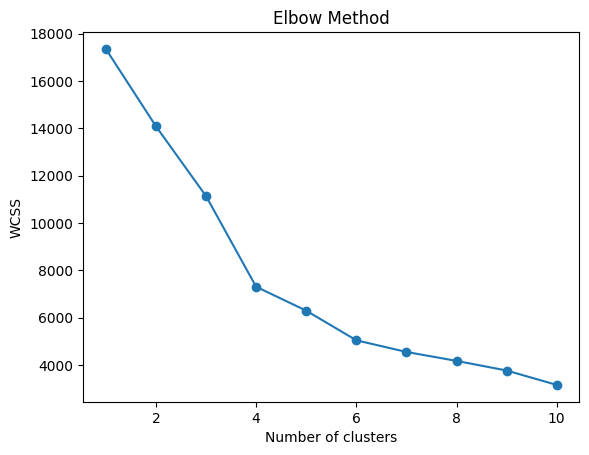

In [76]:
# K-Means Clustering
# using elbow method

wscc = []
for i in range(1,11):
  kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42) # Added random_state for reproducibility
  kmeans.fit(df_rfm_scaled)
  wscc.append(kmeans.inertia_)

plt.plot(range(1,11), wscc, marker = 'o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [77]:
# Fit K-Means with chosen k (example k=4)

kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
df_rfm['k means'] = kmeans.fit_predict(df_rfm_scaled)

**DBSCAN Clustering**

In [78]:
# DBSCAN Clustering

dbscan = DBSCAN(eps=1.5, min_samples=5)
dbscan.fit(df_rfm_scaled)

df_rfm['dbscan'] = dbscan.fit_predict(df_rfm_scaled)
df_rfm.head()

,CustomerID,Recency,Frequency,Monetary,k means,dbscan
0,12346,325,1,77183.60,2,-1
1,12347,1,7,4310.00,0,0
2,12348,74,4,1797.24,0,0
3,12349,18,1,1757.55,0,0
4,12350,309,1,334.40,2,0


**Analyse Clusters**

In [79]:
# analyse dbscan and kmeans clusters

print(df_rfm['dbscan'].value_counts())
print(df_rfm['k means'].value_counts())

# Look at average RFM per cluster
df_rfm.groupby('k means').mean()

dbscan
 0    4306
-1      33
Name: count, dtype: int64
k means
1    1695
0    1671
2     958
3      15
Name: count, dtype: int64


,CustomerID,Recency,Frequency,Monetary,dbscan
k means,,,,,
0,13770.114303,43.549372,5.005984,2215.055650,-0.006583
1,16810.797050,46.091445,4.455457,1667.253323,-0.001770
2,15292.240084,256.906054,1.512526,631.636066,-0.004175
3,15486.533333,5.733333,78.000000,118596.545333,-1.000000


Cluster 0 - **Regular customers**
Recency: 43 days (1.5 months ago)
Frequency: 5 (moderate buyers)
Monetary: 2,200 (decent spend)

Cluster 1 - **Lower-value regulars**
Recency: 46 days (1.5 months ago)
Frequency: 4.5 (moderate buyers)
Monetary: 1,667 (lower spend)

Cluster 2 - **At-risk / churned**
Recency: 257 days (long time ago)
Frequency: 1.5 (rare buyers)
Monetary: 631 (low spend)

Cluster 3 - **VIP / top customers**
Recency: 5 days (very recent)
Frequency: 78 (very frequent)
Monetary: 118,597 (extremely high spend)

In [80]:
df_rfm.groupby('dbscan').mean()

,CustomerID,Recency,Frequency,Monetary,k means
dbscan,,,,,
-1,15091.303030,38.606061,56.151515,75805.919394,1.696970
0,15301.535764,91.923827,3.874361,1488.577000,0.836043


DBSCAN treated the super spenders (high frequency + high monetary) as outliers (Cluster -1), separating them from the bulk.

The majority of customers fall into a moderate-spend, less-frequent cluster (Cluster 0).

Compared to k-means, DBSCAN highlights that the VIPs are extreme outliers, while k-means still tries to fit them into clusters.

**Plot**

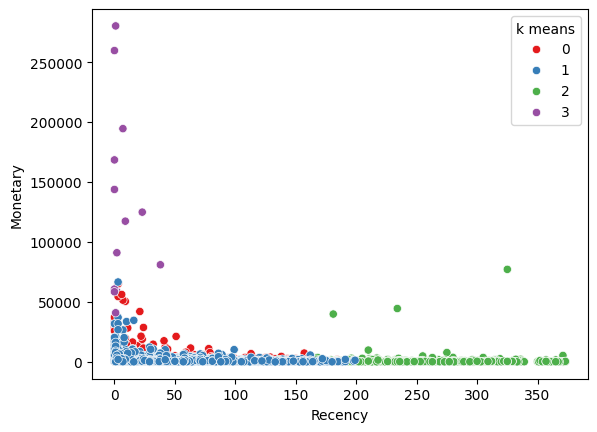

In [81]:
sns.scatterplot(x='Recency', y='Monetary', hue='k means', data=df_rfm, palette='Set1')
plt.show()


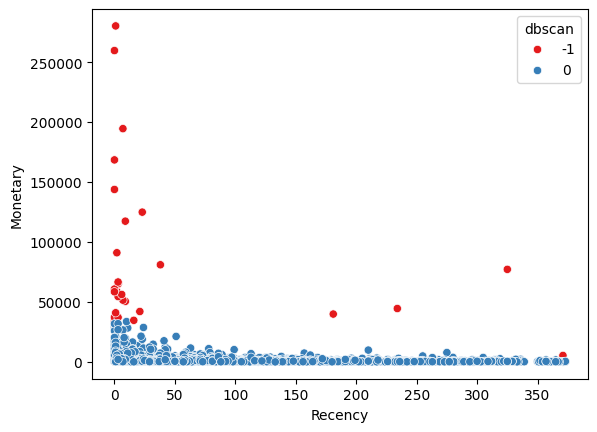

In [82]:
sns.scatterplot(x='Recency', y='Monetary', hue='dbscan', data=df_rfm, palette='Set1')
plt.show()

+1 → clusters are dense and well-separated.

0 → clusters overlap / not clearly separated.

Negative → extremes/outliers or noise.

**Insights**

In [83]:
# k means score and dbsacn score with silouette score

kmeans_score = silhouette_score(df_rfm_scaled, df_rfm['k means'])
dbscan_score = silhouette_score(df_rfm_scaled, df_rfm['dbscan'])

print(f"K-Means Silhouette Score: {kmeans_score:.2f}")
print(f"DBSCAN Silhouette Score: {dbscan_score:.2f}")

K-Means Silhouette Score: 0.39
DBSCAN Silhouette Score: 0.83


Key Insight:

Silhouette score isn't an absolute measure of “better clustering” — it measures how tight and well-separated clusters are given the algorithm's assumptions.


*   K-means gives you practical segments, but with lower separation (hence lower score).
*   DBSCAN gives you a high score, but that's partly because it collapsed everything into one dense cluster and called VIPs “noise”.



Gathering Insights from Both -
Why both differ???

K-Means -
*   Assumes clusters are roughly spherical/equal sized.
*   Minimizes distance to cluster centroids.
*   Forces every point into a cluster (even extreme outliers).
*   That's why it created a “VIP cluster” — because the customers are so different that k-means naturally assigned them their own centroid.


DBSCAN -
*   Density-based: clusters = dense regions, anything sparse = noise.
*   Doesn't force every point into a cluster.
*   It treated the VIPs as outliers because their behavior is so far from the dense bulk of “normal” customers.


So which one is correct?

Both are correct, but they're answering different questions:
K-Means: “How can I partition customers into groups, even if some are rare?”
DBSCAN: “Where are the dense customer segments, and which ones are just anomalies?”

Which one to use?
It depends on your business goal:
1. If you want clear marketing segments (e.g., Regulars, At-risk, VIPs), k-means is more useful, because it gives you interpretable clusters you can target.
2. If you want to detect anomalies/outliers (e.g., spotting rare VIPs separately from the bulk), DBSCAN is better, because it flags unusual patterns.

What I suggest - to use both in combination as a good practice:



*   Use k-means for segmentation of your main customer base.
*   Use DBSCAN to detect anomalies (like extreme VIPs or unusual buyers).

**Segmenting Customers**

In [84]:
# for marketing segments lets set labels for customers

customer_labels = {
    0: 'Regular customers',
    1: 'Lower-value regulars',
    2: 'At-risk / churned',
    3: 'VIP / top customers'
}


In [85]:
df_rfm['Customer Segment'] = df_rfm['k means'].map(customer_labels)
df_rfm.head()

,CustomerID,Recency,Frequency,Monetary,k means,dbscan,Customer Segment
0,12346,325,1,77183.60,2,-1,At-risk / churned
1,12347,1,7,4310.00,0,0,Regular customers
2,12348,74,4,1797.24,0,0,Regular customers
3,12349,18,1,1757.55,0,0,Regular customers
4,12350,309,1,334.40,2,0,At-risk / churned


In [86]:
# Drop the clustering columns if they exist
columns_to_drop = ['k means', 'dbscan']
existing_columns_to_drop = [col for col in columns_to_drop if col in df_rfm.columns]

if existing_columns_to_drop:
    df_rfm.drop(columns=existing_columns_to_drop, inplace=True)
    print(f"Dropped columns: {existing_columns_to_drop}")
else:
    print("Columns 'k means' and 'dbscan' not found in the DataFrame.")

df_rfm.head()

Dropped columns: ['k means', 'dbscan']


,CustomerID,Recency,Frequency,Monetary,Customer Segment
0,12346,325,1,77183.60,At-risk / churned
1,12347,1,7,4310.00,Regular customers
2,12348,74,4,1797.24,Regular customers
3,12349,18,1,1757.55,Regular customers
4,12350,309,1,334.40,At-risk / churned
